If you used the same basic kind of lidar as Ingenuity, with a few clever tweaks, could you profile water?

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# Planck's constant
h = 6.62607015e-34 # J s
c = 2.99792458e8 # m/s

# Specs on the Ingenuity lidar - https://www.garmin.com/en-US/p/557294#specs
lamb = 905e-9 # m
# power = 1.3 # W
power = 0.78 # Adjusted based on Moores's comments

energy_per_photon = h*c/lamb

# Detectors operate at kHz sampling - 
# https://www.baumer.com/us/en/product-overview/distance-measurement/laser-distance-sensors/c/289
#
# Integration time is just one pulse!
sampling_frequency = 5e3

t = 1./sampling_frequency

number_photons = power*t/energy_per_photon
print(number_photons)

710716577005679.9


Text(0, 0.5, 'Earth Extinction (1/km)')

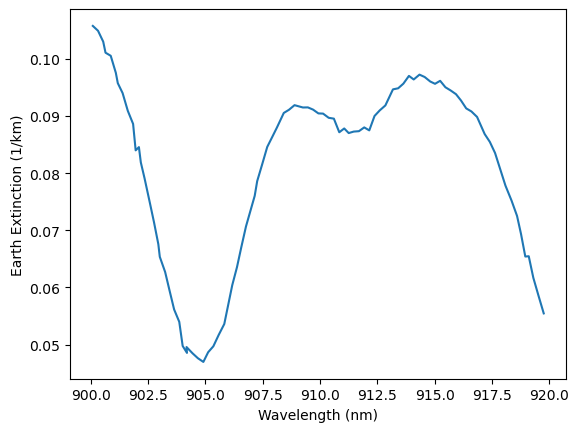

In [5]:
# 2024 Dec 12 - Trying to use Wieger & Gasteiger (2015 - https://amt.copernicus.org/articles/8/3971/2015/amt-8-3971-2015.pdf)
data = np.genfromtxt("WiegerGasteiger2015_Fig2.csv", delimiter=',', names=True)

plt.plot(data['Wavelength'], data['Extinction'])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Earth Extinction (1/km)")

Text(0, 0.5, 'Cross-Section (m^2)')

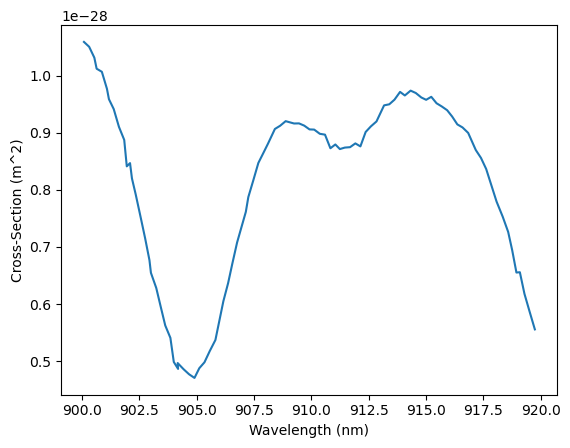

In [32]:
# Let's scale the extinction from Earth to Mars
#
# (extinction) = (atmospheric mass density)/(molecular mass) * (optical cross-section)
# -> (Mars extinction) = (Earth extinction) * (Mars atmospheric mass density)/(Earth atmospheric mass density)
#                                           * (Earth molecular mass)/(Mars molecular mass)
#                                           * (Mars water fraction)/(Earth water fraction)
#
# assuming the optical cross-section isn't too different.

Earth_density = 1.2/4.80659596e-26 # 1/m^3
Mars_density = 0.02/7.3080318e-26 # 1/m^3

# Earth_molecular_mass = 28.946 # g/mol
# Mars_molecular_mass = 43.34 # g/mol

# CO2_molecular_mass = 7.3080318e-26 # kg

Earth_water_fraction = 0.04
# Mars_water_fraction = 210e-6
Mars_water_fraction = 20e-6 # based on Moores's comments

Earth_scale_height = 8.4e3 # km to m
Mars_scale_height = 11e3 # km to m

# plt.plot(data['Wavelength'], Mars_extinction)
# plt.xlabel("Wavelength (nm)")
# plt.ylabel("Mars Extinction (1/m)")

# plt.plot(data['Wavelength'], Mars_cross_section)
# plt.xlabel("Wavelength (nm)")
# plt.ylabel("Cross-Section (m^2)")

cross_section = (data['Extinction']/1000.)/(Earth_density*Earth_water_fraction)

plt.plot(data['Wavelength'], cross_section)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Cross-Section (m^2)")

Text(0, 0.5, 'Mars Extinction (1/m)')

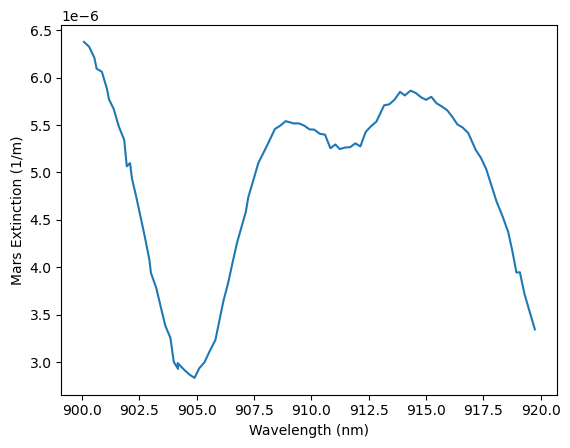

In [33]:
Mars_extinction = cross_section*(Mars_density*Mars_water_fraction)*(Mars_scale_height)

plt.plot(data['Wavelength'], Mars_extinction)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mars Extinction (1/m)")

In [34]:
# At an altitude at which the drone flies, can we tell the difference between the total number of photons 
# in and out of the absorption band?

# Mars surface albedo - https://www.isro.gov.in/mission_global_albedo_map_of_mars.html
albedo = 0.1

path_length = 10. # m

kappa_min = np.min(Mars_extinction)
kappa_max = np.max(Mars_extinction)

# Lemmon+ (2024 - https://www.sciencedirect.com/science/article/pii/S0019103523004001) dust optical depth
total_tau_dust = 8.0 # integrated over the whole atmosphere
dust_scale_height = 10e3 # km to m
dust_extinction_coefficient = total_tau_dust/dust_scale_height # per meter

inband_returned_photons = albedo*number_photons*(1. - path_length*kappa_max) + number_photons*path_length*2*dust_extinction_coefficient
outband_returned_photons = albedo*number_photons*(1. - path_length*kappa_min) + number_photons*path_length*2*dust_extinction_coefficient

print("Difference in transmissivity: ", path_length*(kappa_max - kappa_min))

# Assuming Poisson error bars, 
# how many sigma different are the number of photons returned in and out of band?
print("Integration for one laser pulse: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))

# Not even one-sigma at 10 m
# Integration for one laser pulse:  0.2643155809067568

# Lengthen integration time to 1-s
inband_returned_photons = (albedo*number_photons*(1. - path_length*kappa_max) +\
    number_photons*path_length*2*dust_extinction_coefficient)*(sampling_frequency)
outband_returned_photons = albedo*number_photons*(1. - path_length*kappa_min) +\
    number_photons*path_length*2*dust_extinction_coefficient*(sampling_frequency)
outband_returned_photons = albedo*number_photons*(1. - path_length*kappa_min)*(sampling_frequency)

print("Integration for 1-sec: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))
# Integration for 1-sec:  1.3787770968677375

# Lengthen integration time to 60-s
inband_returned_photons = albedo*number_photons*(1. - path_length*kappa_max)*(sampling_frequency)*60.
outband_returned_photons = albedo*number_photons*(1. - path_length*kappa_min)*(sampling_frequency)*60.

print("Integration for 60-sec: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))
# Integration for 1-sec:  10.679961115777502

Difference in transmissivity:  3.543284961036998e-05
Integration for one laser pulse:  196.11866575433444
Integration for 1-sec:  -64884266.84327147
Integration for 60-sec:  115693.75874745149


Some notes and websites I found useful:
* https://amt.copernicus.org/articles/8/3971/2015/amt-8-3971-2015.pdf
* https://www.garmin.com/en-US/p/557294#specs
* https://www.baumer.com/us/en/product-overview/distance-measurement/laser-distance-sensors/c/289
* https://nssdc.gsfc.nasa.gov/planetary/factsheet/marsfact.html
* https://lidar.jpl.nasa.gov/results/water_studies.php
* file:///Users/brian/Downloads/bams-1520-0477_1994_075_0975_rlpoaw_2_0_co_2.pdf
* https://www.acuitylaser.com/product/laser-sensors/long-range-sensors/ar3000-distance-measurement-sensor/
* https://arxiv.org/pdf/1109.6703
* https://opg.optica.org/oe/fulltext.cfm?uri=oe-23-17-22907&id=324519
* https://www.sciencedirect.com/science/article/pii/S0019103523004001

In [8]:
# 2024 Dec 18 - Trying to use the cross-section around 900 nm - https://amt.copernicus.org/articles/8/3971/2015/amt-8-3971-2015.pdf

sigma_in_band = 2.5e-22/10000. # cm^2 to m^2 at 909 nm
sigma_out_of_band = 1e-25/10000. # cm^2 to m^2 at 906 nm

Earth_density = 1.2 # kg/m^3
Mars_density = 0.02 # kg/m^3
CO2_molecular_mass = 7.3080318e-26 # kg

Earth_water_fraction = 0.04
Mars_water_fraction = 20e-6

Mars_water_density = Mars_density/CO2_molecular_mass*Mars_water_fraction # 1/m^3

# Mars surface albedo - https://www.isro.gov.in/mission_global_albedo_map_of_mars.html
albedo = 0.1

# Let's try to estimate the scattering contribution from dust

# Lemmon+ (2024 - https://www.sciencedirect.com/science/article/pii/S0019103523004001) dust optical depth
total_tau_dust = 8.0 # integrated over the whole atmosphere
dust_scale_height = 10e3 # km to m
dust_extinction_coefficient = total_tau_dust/dust_scale_height # per meter

path_length = 10. # m

Mars_water_column_abundance = Mars_water_density*path_length*2

# dust scattering optical depth
dust_optical_depth = dust_extinction_coefficient*path_length*2.

in_band_optical_depth = Mars_water_column_abundance*sigma_in_band + dust_optical_depth
out_of_band_optical_depth = Mars_water_column_abundance*sigma_out_of_band + dust_optical_depth

# Let's just pretend like we can observe deep in the band and well out of the band.
inband_returned_photons = albedo*number_photons*(1. - in_band_optical_depth)
outband_returned_photons = albedo*number_photons*(1. - out_of_band_optical_depth)

# Assuming Poisson error bars, 
# how many sigma different are the number of photons returned in and out of band?
print("Integration for one laser pulse: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))

print("Integration for 1-sec: ", (outband_returned_photons - inband_returned_photons)/\
      np.sqrt(outband_returned_photons + inband_returned_photons))

Integration for one laser pulse:  723.5288824563693
Integration for 1-sec:  723.5288824563693
